In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.17.1


In [3]:
IMG_ROWS, IMG_COLS = 28, 28
NUM_CLASSES = 10           
BATCH_SIZE = 128
EPOCHS = 15    

In [4]:
print("\n--- Loading Fashion MNIST dataset ---")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


--- Loading Fashion MNIST dataset ---
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)



--- Exploratory Data Analysis ---

Sample images from the training set:




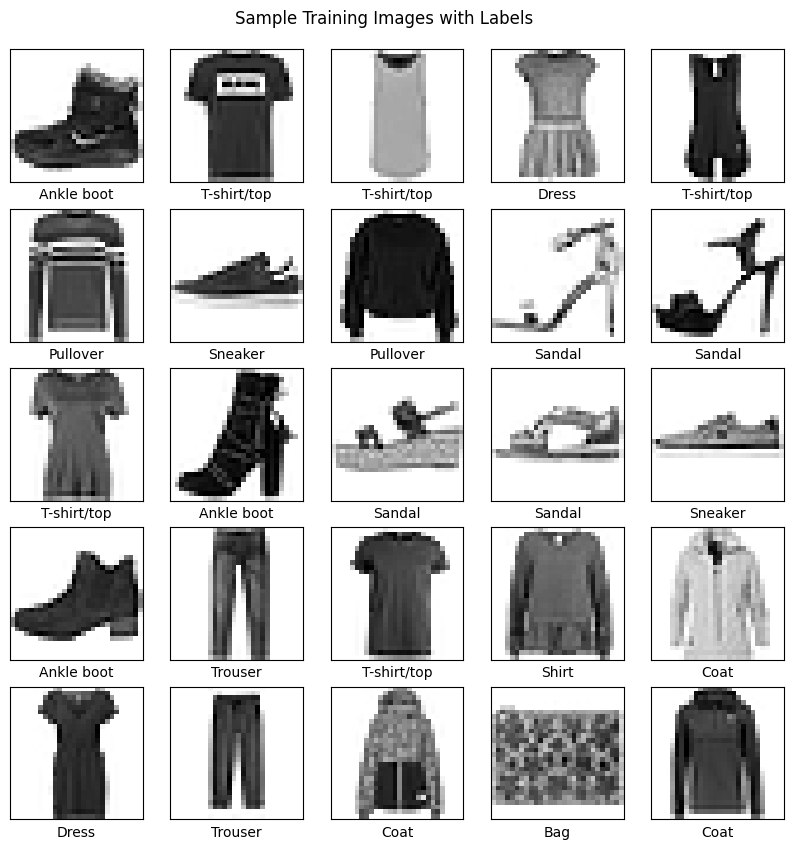

In [6]:
print("\n--- Exploratory Data Analysis ---")

# 4.1 Define Class Names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 4.2 Visualize Sample Images
print("\nSample images from the training set:\n\n")
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary) # Use binary colormap for grayscale
    plt.xlabel(class_names[y_train[i]])
plt.suptitle("Sample Training Images with Labels", y=0.92)
plt.show()


Label Distribution in Training Set:
{'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle boot': 6000}


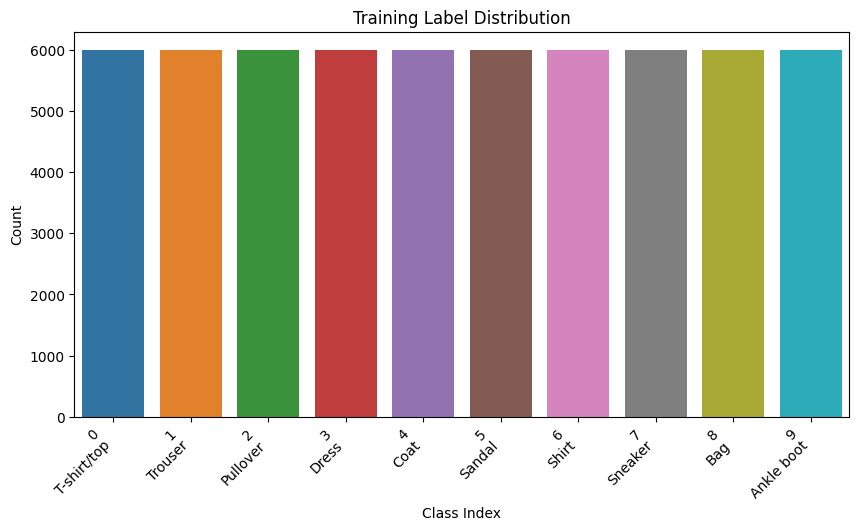

In [7]:
print("\nLabel Distribution in Training Set:")
unique_labels, counts = np.unique(y_train, return_counts=True)
print(dict(zip(class_names, counts)))

plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Training Label Distribution')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.xticks(ticks=range(NUM_CLASSES), labels=[f"{i}\n{name}" for i, name in enumerate(class_names)], rotation=45, ha='right')
plt.show()

In [8]:
print("\n--- Preprocessing Data ---")

# 5.1 Reshape Data for CNN (Add Channel Dimension)
# Keras expects (batch_size, rows, cols, channels)
if keras.backend.image_data_format() == 'channels_first':
    x_train_reshaped = x_train.reshape(x_train.shape[0], 1, IMG_ROWS, IMG_COLS)
    x_test_reshaped = x_test.reshape(x_test.shape[0], 1, IMG_ROWS, IMG_COLS)
    input_shape = (1, IMG_ROWS, IMG_COLS)
else: # 'channels_last'
    x_train_reshaped = x_train.reshape(x_train.shape[0], IMG_ROWS, IMG_COLS, 1)
    x_test_reshaped = x_test.reshape(x_test.shape[0], IMG_ROWS, IMG_COLS, 1)
    input_shape = (IMG_ROWS, IMG_COLS, 1)

print(f"Reshaped x_train shape: {x_train_reshaped.shape}")
print(f"Reshaped x_test shape: {x_test_reshaped.shape}")
print(f"Input shape for CNN: {input_shape}")


--- Preprocessing Data ---
Reshaped x_train shape: (60000, 28, 28, 1)
Reshaped x_test shape: (10000, 28, 28, 1)
Input shape for CNN: (28, 28, 1)


In [9]:
# 5.2 Normalize Pixel Values (Scale to 0-1)
x_train_processed = x_train_reshaped.astype('float32') / 255.0
x_test_processed = x_test_reshaped.astype('float32') / 255.0
print(f"Min/Max pixel value after normalization: {x_train_processed.min()}, {x_train_processed.max()}")

Min/Max pixel value after normalization: 0.0, 1.0


In [10]:
# 5.3 One-Hot Encode Labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)
print(f"Original label example: {y_train[0]}")
print(f"One-hot encoded label example: {y_train_cat[0]}")
print(f"Shape of y_train_cat: {y_train_cat.shape}")
print(f"Shape of y_test_cat: {y_test_cat.shape}")

Original label example: 9
One-hot encoded label example: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Shape of y_train_cat: (60000, 10)
Shape of y_test_cat: (10000, 10)


In [11]:
print("\n--- Building the CNN Model ---")
model = Sequential([
    Input(shape=input_shape), # Explicit Input layer

    # Convolutional Block 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.25), # Optional dropout

    # Convolutional Block 2
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.25), # Optional dropout

    Flatten(), # Flatten the feature maps

    # Dense Classifier Head
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout for regularization
    Dense(NUM_CLASSES, activation='softmax') # Output layer for multi-class classification
])



--- Building the CNN Model ---


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', # Use categorical for one-hot labels
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
print("\n--- Training the Model ---")
history = model.fit(x_train_processed,
                    y_train_cat,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test_processed, y_test_cat),
                    verbose=1)


--- Training the Model ---
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7001 - loss: 0.8377 - val_accuracy: 0.8656 - val_loss: 0.3711
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8629 - loss: 0.3936 - val_accuracy: 0.8766 - val_loss: 0.3307
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8789 - loss: 0.3392 - val_accuracy: 0.8964 - val_loss: 0.2866
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8924 - loss: 0.2964 - val_accuracy: 0.9011 - val_loss: 0.2691
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9047 - loss: 0.2709 - val_accuracy: 0.9104 - val_loss: 0.2520
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9120 - loss: 0.2483 - val_accuracy: 0.9071 - val_loss: 0.2539
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9163 - loss: 0.2293 - val_accuracy: 0.9171 - val_loss: 0.2299
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9218 - l

In [14]:
print("\n--- Evaluating the Model ---")
loss, accuracy = model.evaluate(x_test_processed, y_test_cat, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


--- Evaluating the Model ---
Test Loss: 0.2200
Test Accuracy: 0.9231 (92.31%)



--- Visualizing Training History ---


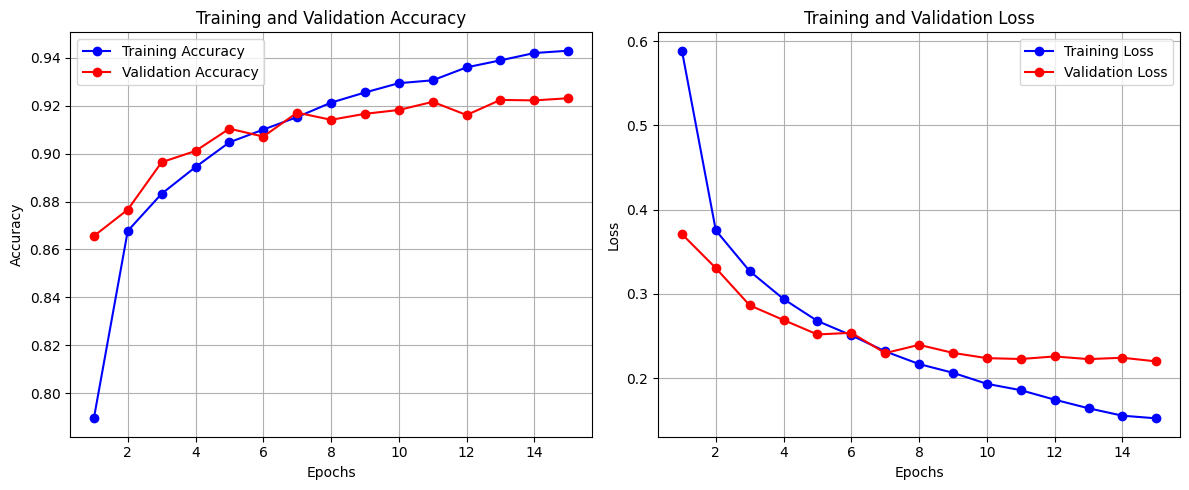

In [15]:
print("\n--- Visualizing Training History ---")
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()